# Task 2: Medical dataset

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression, Ridge, HuberRegressor, Lasso
from sklearn.svm import SVC, LinearSVC
import sklearn.metrics as metrics

import utils

pd.options.display.max_columns = 40

---
## 0. Preliminary Analysis

In [2]:
feat_train = pd.read_csv("./train_features.csv")
labl_train = pd.read_csv("./train_labels.csv")
feat_test = pd.read_csv("./test_features.csv")

In [3]:
feat_train.fillna(0.0, inplace=True)
feat_test.fillna(0.0, inplace=True)
feat_train_reformed = utils.patient_feat_flatten(feat_train)
feat_test_reformed = utils.patient_feat_flatten(feat_test)
# labl_train.sort_values("pid", inplace=True)

In [9]:
ages_idx = pd.MultiIndex.from_tuples([("Age", 0)], names=["Measure", "Time"])
ages_pid = feat_train.loc[:, ["pid", "Age"]].drop_duplicates(subset="pid", keep="first").set_index("pid")
ages_pid = pd.DataFrame(data=ages_pid.to_numpy(), index=ages_pid.index, columns=ages_idx)
ages_pid

Measure,Age
Time,0
pid,
1,34.0
10,71.0
100,68.0
1000,79.0
10000,76.0
...,...
9993,80.0
9995,73.0


In [49]:
ages_pid

,Age
pid,
1,34.0
10,71.0
100,68.0
1000,79.0
10000,76.0
...,...
9993,80.0
9995,73.0
9996,53.0


In [5]:
feat_na_filled = feat_train_pid.fillna(0.0, inplace=False)
feat_na_filled

Measure EtCO2                                                              \
Time       0     1     2     3     4     5     6     7     8     9     10   
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
10        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
100       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1000      0.0  26.0  29.5  30.0  32.5  35.5  37.0  37.0  35.5  30.0  28.5   
10000     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
9993      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
9995      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
9996      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
9998      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
9999      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

Measure        PTT                                         ...   ABPs         \
Time       11   0     1     2    3     4     5    6    7   ...     5      6    
1         0.0  0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0  ...  106.0  112.0   
10        0.0  0.0   0.0   0.0  0.0   0.0  27.8  0.0  0.0  ...  123.0  113.0   
100       0.0  0.0  20.9   0.0  0.0   0.0   0.0  0.0  0.0  ...  113.0  130.0   
1000     29.0  0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0  ...  144.0  175.0   
10000     0.0  0.0  25.7   0.0  0.0   0.0   0.0  0.0  0.0  ...  130.0  132.0   
...       ...  ...   ...   ...  ...   ...   ...  ...  ...  ...    ...    ...   
9993      0.0  0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0  ...   90.0   92.0   
9995      0.0  0.0   0.0   0.0  0.0  55.5   0.0  0.0  0.0  ...  183.0  184.0   
9996      0.0  0.0   0.0   0.0  0.0   0.0   0.0  0.0  0.0  ...  106.0   88.0   
9998      0.0  0.0  34.7   0.0  0.0   0.0   0.0  0.0  0.0  ...  146.0  119.0   
9999      0.0  0.0   0.0  36.4  0.0   0.0   0.0  0.0  0.0  ...  109.0   90.0   

Measure                                       pH                          \
Time        7      8      9      10     11    0     1     2     3     4    
1        121.0  118.0  110.0  124.0  102.0  7.33  7.33  7.37  7.37  7.41   
10       114.0  136.0  140.0  131.0  136.0  0.00  0.00  0.00  0.00  0.00   
100      113.0  113.0  110.0   97.0  116.0  0.00  0.00  0.00  0.00  0.00   
1000     185.0  152.0  152.0  134.0  125.0  0.00  0.00  0.00  0.00  7.30   
10000     98.0  111.0  152.0  141.0  132.0  0.00  7.35  0.00  7.42  7.39   
...        ...    ...    ...    ...    ...   ...   ...   ...   ...   ...   
9993      92.0   95.0   96.0  101.0  101.0  0.00  0.00  0.00  0.00  0.00   
9995     181.0  187.0  187.0  197.0  174.0  0.00  0.00  0.00  0.00  0.00   
9996      80.0   96.0  100.0  100.0   95.0  7.41  0.00  7.36  0.00  0.00   
9998     123.0  142.0  143.0  126.0  156.0  0.00  0.00  0.00  0.00  0.00   
9999     110.0  123.0  138.0  125.0  128.0  0.00  0.00  0.00  0.00  0.00   

Measure                                         Age  
Time       5    6    7     8     9     10   11   0   
1        0.00  0.0  0.0  0.00  7.39  7.39  0.0  0.0  
10       0.00  0.0  0.0  0.00  0.00  0.00  0.0  0.0  
100      0.00  0.0  0.0  0.00  0.00  0.00  0.0  0.0  
1000     0.00  0.0  0.0  0.00  0.00  0.00  0.0  0.0  
10000    7.40  0.0  0.0  0.00  0.00  0.00  0.0  0.0  
...       ...  ...  ...   ...   ...   ...  ...  ...  
9993     0.00  0.0  0.0  0.00  0.00  0.00  0.0  0.0  
9995     0.00  0.0  0.0  0.00  0.00  0.00  0.0  0.0  
9996     7.41  0.0  0.0  7.43  0.00  0.00  0.0  0.0  
9998     0.00  0.0  0.0  0.00  0.00  0.00  0.0  0.0  
9999     0.00  0.0  0.0  0.00  0.00  0.00  0.0  0.0  

[18995 rows x 409 columns]

In [5]:
logit_classifier = LogisticRegression(penalty="l2", C=1, fit_intercept=True, solver="sag", max_iter=500)
logit_classifier.fit(feat_na_filled, labl_train.iloc[:, 1])

E:\Miniconda3\envs\intro-ml\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [6]:
prob_positive = logit_classifier.predict_proba(feat_na_filled)[:, 1]
prob_positive

array([0.86988127, 0.07813051, 0.22714398, ..., 0.48809049, 0.03229781,
       0.06534028])

In [20]:
svm_classifier = LinearSVC(fit_intercept=True)
svm_classifier.fit(feat_na_filled, labl_train.iloc[:, 1])

E:\Miniconda3\envs\intro-ml\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [21]:
func_pred = svm_classifier.predict(feat_na_filled)
func_val = svm_classifier.decision_function(feat_na_filled)
func_pred_val = np.zeros(func_val.shape)
func_pred_val[func_val > 0] = 1.

In [27]:
prob_svm = 1/(1 + np.exp(-func_val))
prob_svm

array([0.66652946, 0.20404087, 0.28653263, ..., 0.45224051, 0.20716866,
       0.18794192])

In [28]:
metrics.roc_auc_score(labl_train.iloc[:, 1], prob_svm)

0.8759529812688828

In [52]:
vital_predictor = Lasso(alpha=1, fit_intercept=True).fit(feat_na_filled, labl_train["LABEL_RRate"])

In [53]:
0.5 + 0.5*np.maximum(0, metrics.r2_score(labl_train["LABEL_RRate"], vital_predictor.predict(feat_na_filled)))

0.636415255250034

In [4]:
df_summary = feat_train.describe()
df_summary.drop(columns=["Time"])
df_summary.loc["nunique", :] = feat_train.nunique()
df_summary = df_summary.loc[["count", "nunique", "min", "max", "mean", "std"]]
df_summary

,pid,Time,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH
count,227940.000000,227940.000000,227940.000000,9783.000000,10299.000000,20105.000000,10756.000000,81115.000000,22295.000000,12559.00000,19887.000000,187785.000000,2493.000000,11590.000000,19083.000000,17792.000000,21043.000000,5761.000000,26602.000000,18035.000000,13014.000000,47036.000000,195889.000000,17523.000000,28393.000000,152418.000000,17830.000000,5708.000000,195192.000000,719.000000,13917.000000,27297.000000,200128.000000,5326.000000,3776.000000,191650.000000,25046.000000
nunique,18995.000000,61.000000,76.000000,105.000000,940.000000,198.000000,919.000000,15.000000,257.000000,180.00000,240.000000,69.000000,538.000000,135.000000,529.000000,877.000000,370.000000,737.000000,82.000000,709.000000,65.000000,842.000000,220.000000,69.000000,311.000000,397.000000,389.000000,419.000000,68.000000,127.000000,86.000000,564.000000,153.000000,205.000000,858.000000,225.000000,86.000000
min,1.000000,1.000000,15.000000,10.000000,12.500000,1.000000,0.200000,21.000000,3.300000,0.00000,-29.000000,1.000000,34.000000,0.200000,0.100000,0.100000,10.000000,5.000000,0.000000,2.000000,24.000000,15.000000,20.000000,0.500000,1.300000,20.000000,1.000000,12.000000,20.000000,0.010000,66.000000,9.400000,23.000000,0.100000,0.010000,21.000000,6.820000
max,31658.000000,315.000000,100.000000,100.000000,250.000000,268.000000,31.000000,42.000000,23.800000,50.00000,100.000000,97.000000,1179.000000,16.400000,440.000000,41.900000,100.000000,9961.000000,4000.000000,2322.000000,100.000000,952.000000,300.000000,9.600000,10.750000,298.000000,20.600000,3833.000000,100.000000,21.200000,141.000000,63.400000,191.000000,46.500000,440.000000,287.000000,7.780000
mean,15788.831219,7.014399,62.073809,32.883114,40.091310,23.192664,2.859716,36.852136,10.628208,23.48810,-1.239284,18.154043,262.496911,3.612519,11.738649,1.495777,41.115696,193.444888,0.701666,204.666426,93.010527,142.169407,82.117276,2.004149,4.152729,64.014711,7.161149,97.796163,97.663449,1.390723,106.260185,31.283090,84.522371,1.640941,7.269240,122.369877,7.367231
std,9151.896286,4.716103,16.451854,7.802065,26.034961,20.024289,2.428368,0.875152,2.074859,4.40378,4.192677,5.037031,133.020910,1.384462,10.088872,1.898112,8.929873,682.836708,24.522126,104.156406,10.887271,56.894530,16.471871,0.437286,0.670168,13.920097,2.812067,122.773379,2.786186,2.792722,5.916082,5.770425,17.643437,3.244145,25.172442,23.273834,0.074384


In [22]:
hist_names = list(feat_train.iloc[:, np.array(df_summary.loc["count"] < 4e+4)].columns)

# fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(24, 15))
# axes = axes.flatten()
# for i, result_name in enumerate(hist_names):
#     print(i, result_name)
#     sns.histplot(feat_train[result_name], ax=axes[i])
#     plt.title(result_name)
# plt.show()

# len(hist_names)


# feat_train[feat_train["FiO2"] > 1]
labl_train[labl_train.pid.isin(set(feat_train[feat_train["FiO2"] > 1].pid))]
# feat_train[feat_train["FiO2"] > 1].pid

,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
6395,19657,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,22.3,76.8,93.000000,91.0
6500,19810,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,16.2,67.1,99.300000,83.7
7145,2076,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,19.2,88.8,92.700000,90.3
12928,29436,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,11.6,67.0,78.666667,88.9
14290,31491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.5,96.0,98.800000,73.5
14787,3697,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,15.8,88.5,98.700000,110.1
16146,5695,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,15.9,82.0,98.700000,97.4


### Check vitals of a patientresult_name

In [36]:
df_patient = feat_train[feat_train["pid"] == 1]
df_patient

,pid,Time,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH
0,1,3,34.0,NaN,NaN,12.0,NaN,36.0,8.7,24.0,-2.0,16.0,NaN,NaN,6.3,NaN,45.0,NaN,NaN,NaN,NaN,NaN,84.0,1.2,3.8,61.0,NaN,NaN,100.0,NaN,114.0,24.6,94.0,NaN,NaN,142.0,7.33
1,1,4,34.0,NaN,NaN,NaN,NaN,36.0,NaN,NaN,-2.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,81.0,NaN,NaN,62.5,NaN,NaN,100.0,NaN,NaN,NaN,99.0,NaN,NaN,125.0,7.33
2,1,5,34.0,NaN,NaN,NaN,NaN,36.0,NaN,NaN,0.0,18.0,NaN,NaN,NaN,NaN,43.0,NaN,0.4,NaN,NaN,NaN,74.0,NaN,NaN,59.0,NaN,NaN,100.0,NaN,NaN,NaN,92.0,NaN,NaN,110.0,7.37
3,1,6,34.0,NaN,NaN,NaN,NaN,37.0,NaN,NaN,0.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,NaN,NaN,49.5,NaN,NaN,100.0,NaN,NaN,NaN,88.0,NaN,NaN,104.0,7.37
4,1,7,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,1.8,NaN,48.0,NaN,NaN,100.0,NaN,NaN,22.4,81.0,NaN,NaN,100.0,7.41
5,1,8,34.0,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,0.4,NaN,NaN,NaN,68.0,1.8,NaN,51.0,NaN,NaN,100.0,NaN,NaN,22.4,82.0,NaN,NaN,106.0,NaN
6,1,9,34.0,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,NaN,NaN,46.0,NaN,NaN,100.0,NaN,NaN,NaN,67.0,NaN,NaN,112.0,NaN
7,1,10,34.0,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0,NaN,NaN,47.0,NaN,NaN,100.0,NaN,NaN,NaN,62.0,NaN,NaN,121.0,NaN
8,1,11,34.0,NaN,NaN,12.0,NaN,NaN,8.5,26.0,NaN,12.0,NaN,4.6,4.7,0.5,NaN,NaN,NaN,143.0,NaN,120.0,67.0,2.1,4.1,47.0,7.6,NaN,100.0,NaN,111.0,23.8,58.0,NaN,NaN,118.0,NaN
9,1,12,34.0,NaN,NaN,12.0,NaN,38.0,8.5,26.0,0.0,18.0,NaN,NaN,4.7,NaN,42.0,NaN,0.4,NaN,NaN,NaN,62.0,2.1,4.1,44.0,NaN,NaN,100.0,NaN,111.0,23.8,66.0,NaN,NaN,110.0,7.39


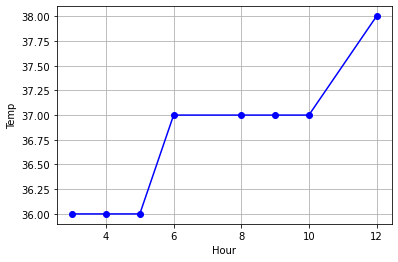

In [50]:
vital_name = "Temp"

idx_val = ~df_patient[vital_name].isna()
plt.plot(df_patient.Time[idx_val], df_patient[vital_name][idx_val], 'bo-')
plt.xlabel("Hour")
plt.ylabel(vital_name)
plt.grid()
plt.show()

---

## 1. Test prediction

---

## Checking Results

In [56]:
result_jdy = pd.read_csv("../JDY/task2a-fill0/result_prob_fill0.csv", header=None)
result_jdy.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
count,18995.000000,12664.0,12664.0,12664.000000,12664.000000,12664.000000,12664.0,12664.000000,12664.0,12664.0,12664.0,18995.000000,18995.000000,18995.000000,1.899500e+04,18995.000000,18995.000000,18995.000000,18995.000000,1.899500e+04,18995.000000
mean,15788.831219,0.0,0.0,0.000158,0.000079,0.000158,0.0,0.000079,0.0,0.0,0.0,0.268281,0.078805,0.468562,3.676804e-01,0.240590,0.200210,0.099828,0.233720,3.390366e-02,0.066159
std,9152.117122,0.0,0.0,0.012566,0.008886,0.012566,0.0,0.008886,0.0,0.0,0.0,0.009125,0.003948,0.030249,5.292142e-02,0.011309,0.010012,0.008283,0.009091,1.094473e-02,0.006737
min,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.076440,0.022829,0.000042,2.191632e-10,0.023678,0.035134,0.000012,0.195265,1.346345e-09,0.018480
25%,7879.500000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.268148,0.078958,0.473452,3.903406e-01,0.240813,0.200974,0.100143,0.231974,3.383694e-02,0.066136
50%,15726.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.268148,0.078958,0.473452,3.903406e-01,0.240813,0.200974,0.100143,0.231974,3.383694e-02,0.066136
75%,23724.500000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.268148,0.078958,0.473452,3.903406e-01,0.240813,0.200974,0.100143,0.231974,3.383694e-02,0.066136
max,31658.000000,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,0.0,0.0,0.0,0.433783,0.143377,0.676547,3.903406e-01,0.541067,0.449524,0.767027,0.323386,9.491915e-01,0.270147


In [57]:
metrics.roc_auc_score(labl_train.iloc[:, 1], result_jdy.iloc[:, 1])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [60]:
result_jdy.iloc[:, 11:]

,11,12,13,14,15,16,17,18,19,20
0,0.262184,0.078958,0.473452,0.390341,0.240813,0.200974,0.100143,0.231974,0.033837,0.066136
1,0.268148,0.078958,0.473452,0.390341,0.240813,0.200974,0.100502,0.231974,0.033837,0.066136
2,0.268148,0.078958,0.470282,0.239808,0.239357,0.200974,0.100106,0.231974,0.034247,0.066136
3,0.289598,0.078958,0.473452,0.390341,0.240813,0.178110,0.100143,0.231136,0.033837,0.066136
4,0.268148,0.078958,0.473452,0.390341,0.240813,0.200974,0.100208,0.231974,0.033837,0.066136
...,...,...,...,...,...,...,...,...,...,...
18990,0.268148,0.067433,0.473452,0.390341,0.240813,0.184293,0.100143,0.231974,0.033837,0.066136
18991,0.268148,0.078958,0.473452,0.390341,0.240813,0.200974,0.100143,0.231974,0.033837,0.066136
18992,0.270294,0.078958,0.473452,0.390341,0.240813,0.200974,0.100143,0.231974,0.033837,0.066136
18993,0.268148,0.078958,0.473452,0.390341,0.240813,0.200974,0.100143,0.231974,0.033837,0.066136
